# Acoustic Positioning System Lab 1: Cross-Correlation and TDOAs

### EECS16A: Designing Information Devices and Systems I, Fall 2020

# Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Introduction](#overview)
    * [Basic Principles of Operation](#bpo)
    * [Overview](#background)

* [Task 1: Measuring the Similarity of Two Signals](#task1)
* [Task 2: Extracting information](#task2)
* [Task 3: Detecting Real Signals](#task3)
* [Task 4: Separating Signals and Beacons](#task4)
* [Task 5: Computing Distances](#task5)
    * [Task 5a: Identifying Offsets](#task5a)
    * [Task 5b: Combining Functions](#task5b)
    * [Visualization](#visualization)
* [Task 6: Testing Signal to Offset Conversion with Real Data](#task6)
* [Checkoff](#checkoff)
    
<a id='instructions'></a>
## Instructions
* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.
* When you finish, submit a checkoff request to get checked off for this lab. Be ready to answer a few questions to show your understanding of each section.
* Labs will be graded based on completion for teams of 2-4 students.

<a id='policies'></a>
## Lab Policies
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are free to stay for the full allotted time and hack around with the lab setup or code, but please reserve the GSI's time for lab-related questions.**
* **Keep food and drinks away from your devices / equipment.**

## Introduction

This is a long lab, but it is all software. The entire lab is done in this Jupyter notebook.

We use various positioning systems every day. The most commonly used such system is the [Global Positioning System (GPS)](http://en.wikipedia.org/wiki/Global_Positioning_System). The navigation systems in cars, Google Maps, cell phones, and even rockets and spaceships all use GPS.

In this lab, we are going to explore basic navigation systems and build our own. At the end of this lab, you will have written software (and tested it on real data) that can determine the location of a receiver in 2D space!
### Run the cell below to import the necessary helper functions.

In [1]:
%pylab inline
%run support_code/APS.py
%run support_code/helper_functions.py

Populating the interactive namespace from numpy and matplotlib


<a id='bpo'></a>
## Basic Principles of Operation
GPS satellites broadcast a variety of measurements such as the satellite's position and velocity, as well as time, using a very precise clock. GPS receivers make use of the fact that light propagates at a known speed: $3\times 10^8 ms^{-1}$. A receiver can therefore compute its distance to the satellite by measuring how long it takes the GPS signal to travel from the satellite to the receiver, using the speed of light and the known time that the signal was broadcasted from the satellite.

<br>
<center>
<img src="img/wk1_standard_gps.png" align="center" style="height:250px">
    
**Source**: [Kathleen Cantner, AGI](http://www.earthmagazine.org/article/precise-fault-how-gps-revolutionized-seismic-research)
</center>

We will instead explore an Acoustic Positioning System, using speakers as signal emitters to emit sound (the signal), and using microphones as receivers. We can similarly determine the distance to each emitter based on the delay between the times at which we receive each signal. We will explore this idea further through the course of this lab, developing the theory and requisite software utilities that will be necessary when working with the real setup in APS 2.

<a id='background'></a>
## Overview
The block diagram below describes the system at a high level. 
<br>
First, each speaker transmits a unique signal. The combined signal from all speakers is then recorded by the microphone and converted to a format that is convenient for further processing. 
<br>
Next, the component signal from each speaker is identified from the received total signal using cross-correlation analysis, and the corresponding time differences are used to determine the receiver's location.

<center>
<img src="img/signals.png" align="center" style="height:450px">
</center>

<a id='task1'></a>
## <font color="blue">Task 1: Measuring the Similarity of Two Signals
    
Our APS setup will use multiple speakers as 'beacons' to emit signals, and a single microphone receiver. The receiver will receive the sum of all the emmitted signals at various delays, depending on the relative distances between the speakers and microphone. To identify each speaker's emitted signal from the received signal, as well as the time delay associated with each component, we will use **cross-correlation** analysis. In particular, the combined recieved signal will be cross correlated with stored copies of **each** speaker's unique emitted signal.

**[Cross-correlation](http://en.wikipedia.org/wiki/Cross-correlation)** is a measure of similarity between two functions - in this case these 'functions' will be vectorized time domain signals. It is a mathematical operation defined by taking successive inner products as one vector 'slides past the other', roughly speaking. Intuitively this is a measure of the 'overlap' between two signals as one signal is shifted in time. For discrete signals, the 'overlap' at time $t$ of the received signal and a copy of a particular speaker generated signal is the inner product of the received signal at that time and a shifted version of the stored copy. Both a mathematical definition and an animation are shown below where $x$ and $y$ are real valued functions.

You have learned how to calculate the linear cross-correlation between two generic signals. Recall that for two signals $x$ and $y$, the $m^{th}$ element of the linear cross-correlation vector $\vec{\rho_{xy}}$ is defined below:  

$$corr_{\vec{x}}(\vec{y})[m]=\vec{\rho_{xy}}[m] \stackrel{\mathrm{def}}{=} \sum_{n=-\infty}^{\infty} x[n] y[n-m]$$

<img src="img/square_triangle_xcorr.gif" border="0" alt="Animation demonstrating cross-correlation." style="height:300px">
<!--- <img src="img/cross_correlation_animation_auto-tune.gif" border="0" alt="Animation demonstrating cross-correlation."> --->

$\rho_{xy}[m]$ is the inner product of two vectors that have been zero-padded: $\vec{x}[n]$ and $\vec{y}[n-m]$, where $m$ is an integer between $-\infty$ to $\infty$. $\vec{y}[n-m]$ is $\vec{y}$ delayed by $m$ discrete time steps. In the above animation, the red signal is shifted by various time steps. The value of the black signal at a particular time is the inner product of the shifted red signal at the corresponding time shift and the blue signal. Observe that the red signal has been zero-padded on both sides to match the length of the blue signal. The blue signal is also zero-padded such that the correlation vector (black) contains entries for all valid overlaps betweenthe two signals.

In this lab we will be using a variant of linear cross-correlation called **infinitely periodic linear cross-correlation**. The difference between finite linear cross-correlation and infinitely periodic cross-correlation is that <span style='color:red'><b> we treat both signals as repeating infinitely in time instead of zero padding the signals.</b></span>  The original signal is effectively padded with a copy of itself infinitely many times. Of course, we must ultimately choose a finite length for the calculated cross-correlation and truncate it as such.

Run the code below to view a demo of how infinitely periodic cross-correlation works. The demo shows the inputs and outputs to an infinitely periodic cross-correlation function, as well as the relevant shifts and periodicity of the involved signals. Notice how the stationary signal 'wraps around' periodically. (Due to this 'wrap around', the stationary red signal appears to slide left and the sliding blue signal appears stationary. Actually, the blue sliding signal slides right and the red stationary signal 'wraps around'.) 

input stationary_signal: [3 1 0 0 0 1]
input sliding_signal: [1 2 3 2 1 0]
cross-correlation:[5, 2, 5, 10, 13, 10]


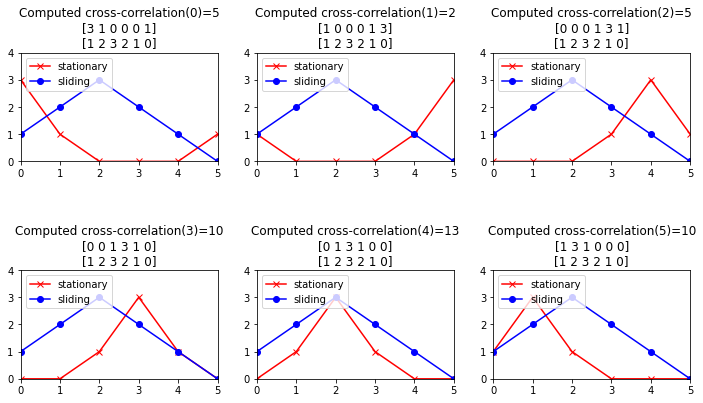

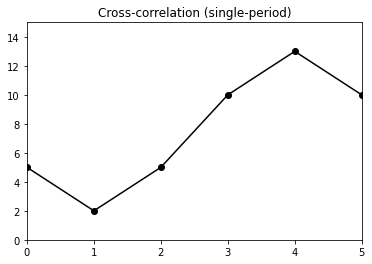

In [2]:
cross_corr_demo_1()

In the above example with $\vec{x} = \begin{bmatrix} 3 & 1 & 0 & 0 & 0 & 1\end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} 1 & 2 & 3 & 2 & 1 & 0\end{bmatrix}^T$, the resultant infinitely periodic cross-correlation vector is:

$$ v = \begin{bmatrix} 5 \\ 2 \\ 5 \\ 10 \\ 13 \\ 10 \end{bmatrix} $$

Where $$ v[0] = \left< \begin{bmatrix} 3 \\ 1 \\ 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}, \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \\ 1 \\ 0 \end{bmatrix} \right> = 5 \hspace{15pt}
v[1] = \left< \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 1 \\ 3 \end{bmatrix}, \begin{bmatrix}  1 \\ 2 \\ 3 \\ 2 \\ 1 \\ 0 \end{bmatrix}\right> = 2 \hspace{15pt} ... $$ and so on.


**<font color="red"> Based on the cross-correlation plot, by how many samples (and in which direction) should the blue signal be shifted to maximize the cross-correlation between the two signals?** 

4 to the right

What happens if we cross correlate for longer than one period? We can analyze this case by repeating the above example for two periods instead.

input stationary signal: [3 1 0 0 0 1 3 1 0 0 0 1]
input sliding signal: [1 2 3 2 1 0 1 2 3 2 1 0]
cross-correlation:[10, 4, 10, 20, 26, 20, 10, 4, 10, 20, 26, 20]


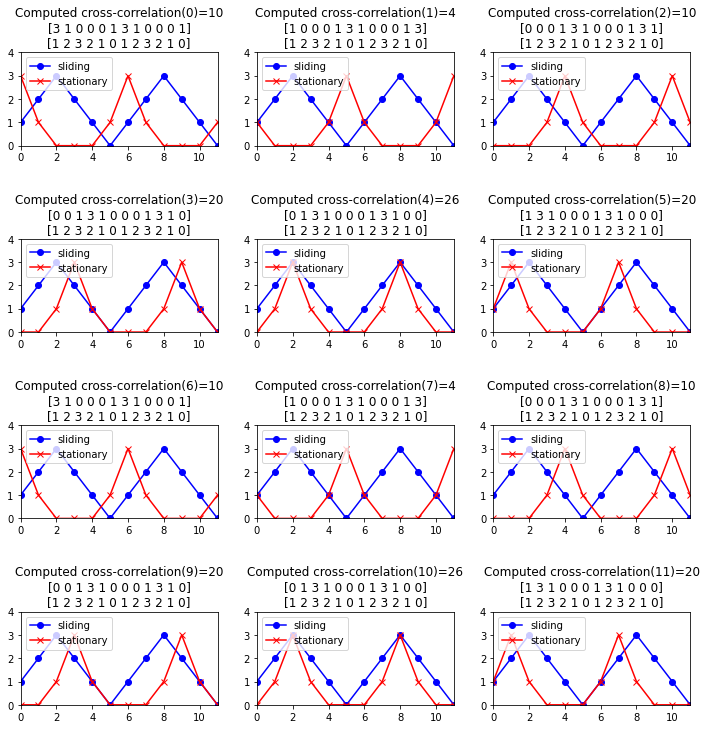

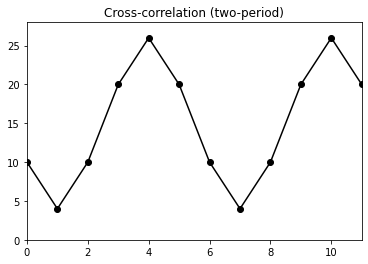

In [3]:
cross_corr_demo_2()

For two periods, $\vec{x} = \begin{bmatrix} 3 & 1 & 0 & 0 & 0 & 1 & 3 & 1 & 0 & 0 & 0 & 1 \end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} 1 & 2 & 3 & 2 & 1 & 0 & 1 & 2 & 3 & 2 & 1 & 0 \end{bmatrix}^T$ .

The infinitely periodic linear cross-correlation vector is now:

$$ v = \begin{bmatrix} 10 \\ 4 \\ 10 \\ 20 \\ 26 \\ 20 \\ 10 \\ 4 \\ 10 \\ 20 \\ 26 \\ 20 \end{bmatrix}$$

**<font color="red"> What is the relationship between the two-period cross-correlation and the single-period cross-correlation?** <br>

**`4 and 10, they are both duplicated`**

Unsurprisingly, the  two-period cross-correlation vector does not give us any new information. The two-period cross-correlation vector is simply the single period vector but with doubled values repeated twice. 

**NOTE**: In the real world, we might cross correlate $\vec{x}$ and $\vec{y}$ multiple times. This is because $\vec{x}$ and $\vec{y}$ may not be perfectly $N$-periodic due to noise affecting values of the signal at certain times. We compensate by using multiple periods of the signals when calculating cross-correlations so that we have multiple copies of the cross-correlation data. These copies can then be averaged to return a good approximation of the noise free data. Data redundancy for noise reduction will be explored later in this lab.

**Below, you are given a cross-correlation function that performs infinitely periodic cross-correlation on two signals using `np.correlate`.**
    
```python
def cross_correlation(stationary_signal, sliding_signal):
    """Compute the cross_correlation of two given signals    
    Args:
    stationary_signal (np.array): input signal 1
    sliding_signal (np.array): input signal 2
    
    Returns:
    cross_correlation (np.array): infinitely periodic cross-correlation of stationary_signal and sliding_signal
    
    >>> cross_correlation([0, 1, 2, 3], [0, 2, 3, 0])
    [8, 13, 6, 3]
    """
    inf_stationary_signal = np.concatenate((stationary_signal ,stationary_signal))
    entire_corr_vec = np.correlate(inf_stationary_signal, sliding_signal, 'full')
    return entire_corr_vec[len(sliding_signal)-1: len(sliding_signal)-1 + len(sliding_signal)]

```



Run the following cell to display an interactive plot of `stationary_signal`, `sliding_signal`, and the resulting infinite periodic linear cross-correlation vector. Set the offset slider to different values to visualize the "infinite periodic" part of the stationary signal and understand the relationship between the offset and correlation result.

In [4]:
inf_periodic_cross_corr()

interactive(children=(IntSlider(value=0, description='offset', max=8, min=-8), Output()), _dom_classes=('widge…

**Notice that the value of correlation (on the y axis of the lower subplot) is highest when the orange and blue signals overlap the most. Similarly, the value is lowest when the signals overlap the least.** This elucidates how cross-correlation measures the similarity between two signals at different time shifts.

<a id='task2'></a>
## <font color="blue">Task 2: Extracting Information

The acoustic positioning system we will design uses speakers as *beacons* that each transmit a (known) unique *beacon signal*. The beacon signals will be used to determine the position of a *receiver* - a microphone. Figure 3a shows examples of waveforms generated by a two beacon system. The beacons are synchronized, i.e all beacon signals are transmitted from their respective beacons simultaneously. Figure 3b demonstrates an example of a  receiver that is further away from beacon 2 than beacon 1, consequently receiving the beacon signal from beacon 2 **after** the beacon signal from beacon 1.


<img src="img/Slide2.tiff.png" width=700px></img>
<h4><center>Figure 3</center></h4>

The raw signal that the receiver measures shown in Figure 4a (black), is a superposition of beacon signal 1 and a delayed beacon signal 2. We can cross-correlate this received signal  with stored copies of each unique beacon signal to determine when each beacon signal arrived at the receiver. For a given beacon signal, this will be the time index that corresponds to the maximum cross-correlation with the stored copy of that particular beacon signal. 

<img src="img/Slide3.tiff.png" width=700px></img>
<h4><center>Figure 4</center></h4>

Notice that in Figure 4b, the cross-correlation of the received signal with a stored copy of beacon signal 1 attains its maximum 3 milliseconds **before** the cross-correlation of the received signal with beacon signal 2 is maximized. We can therefore infer that beacon signal 1 was received 3 milliseconds before beacon signal, and that the distance of the microphone from the first beacon is less than the distance of the microphone from the second beacon.

Although though the two beacon signals are different, notice that the cross-correlation **between the two beacon signals** is still non-zero. This is fine for our purposes, and will still allow us for robust identification of beacon signals. In particular we only require that: 

* The cross-correlation **between different beacon signals** is **small**.
* The cross-correlation of a beacon signal with itself (autocorrelation) is **small** for **non zero shifts**. 
* The autocorrelation of a beacon signal with itself is **large** at **zero shift**.

If these conditions hold, we can still identify the beacon signals that a received signal is composed of, since the cross-correlation between a beacon signal and the received signal at the correct offset (i.e where the overlap between the beacon signal and the corresponding component in the received signal is maximized) will always be considerably larger than other cross-correlation values. 

Real Global Positioning Systems deal with this problem by using pseudorandom binary sequences (signals composed of just 1s and 0s), also known as **Gold Codes**, constructed with the three properties described above. The theory and implementation of these signals is beyond the scope of this class. We have provided a large set of Gold Codes that are designed to work well for our purposes. 

Run the next cell to simulate three beacons that each produce a unique gold code.

In [5]:
sliderPlots()

interactive(children=(IntSlider(value=0, description='delay_samples0', max=500, min=-500, step=10), IntSlider(…

The sliders control the delay of each beacon (in units of samples). Experiment with the delay values for each beacon and observe how the cross-correlation plot changes. If the slider doesn not appear or work for some reason, you can manually change the values in the tuples for `delay_samples0`, `1`, and `2`. For example, try `delay_samples0 = (-300, 700, 10)` and see how the plot changes.

**<font color="red">Pick some non-zero values for the sliders and comment on the offset corresponding to maximum cross-correlation. What is the relationship between the offset and the delay for this part?**

**`The closer the delays are together, the greater the correlation between them`**

If you are given some beacon signals (gold codes) and a received signal that is a composition of these gold codes at different delays, how would you calculate when (in samples) each beacon signal arrived at the receiver?

**<font color="red">Implement a helper function `identify_peak` which takes in a signal with a single global maximum as an input and returns the index of this global maximum.** <font color="red">Note that the signals are zero-indexed, as shown in the example input and output of the function below.

In [6]:
def identify_peak(signal):
    """Returns the index of the peak of the given signal.
    Args:
    signal (np.array): input signal
    
    Returns:
    index (int): index of the peak
    
    >>> identify_peak([1, 2, 5, 7, 12, 4, 1, 0])
    4
    >>> identify_peak([1, 2, 2, 199, 23, 1])
    3
    """
    return np.argmax(signal)

**<font color="red">Verify the following test for `identify_peak`.**

In [7]:
test(cross_correlation, identify_peak, 2)

Test 2 Identify peaks Passed: Your peaks [3,4], Correct peaks [3,4]


<a id='task3'></a>
## <font color="blue">Task 3: Detecting Real Signals

We will now test the functions you have written with real data.

For your convenience, we have pre-recorded some audio samples for you to use for the rest of this lab from the real setup that you will use in APS 2. The code block below will load a test signal (in blue) and test the code you have written, displaying the signal cross correlated with four known signals. This might take a while ($\approx 30$ seconds).

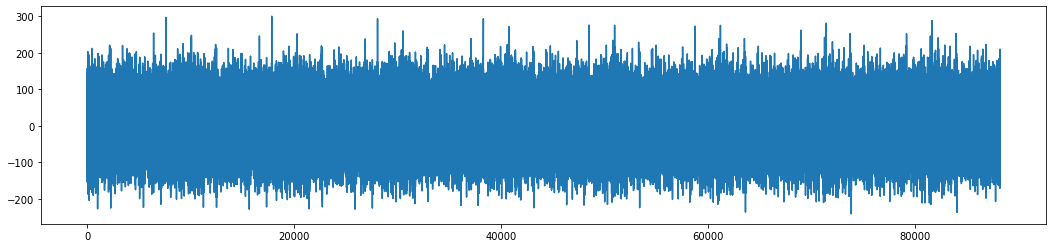

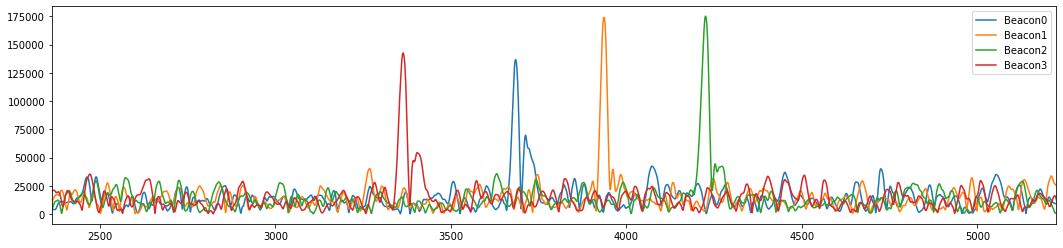

In [8]:
Lab.rawSignal = np.load('sig.npy')
Lab.load_corr_sig(identify_peak)

You should see four discernible peaks after cross-correlating the signals. 

<a id='task4'></a>
# <span style="color:blue">Task 4: Separating Signals and Beacons</span>

Recall that we only have a single receiver (microphone) receiving signals from multiple beacons (speakers). We use infinitely periodic cross-correlation to determine the time (in units of samples) at which each signal arrives after some reference time. This process is called *signal separation*. We have provided you with the following function to do this:

```python
def separate_signal(raw_signal):
    """Separate the beacons by computing the cross correlation of the raw signal 
    with the known beacon signals.

    Args:
    raw_signal (np.array): raw signal from the microphone composed of multiple beacon signals
    
    Returns (list): each entry should be the cross-correlation of the signal with one beacon
    """
    Lperiod = len(beacon[0])
    Ncycle = len(raw_signal) // Lperiod
    for ib, b in enumerate(beacon):
        c = cross_correlation(raw_signal[0:Lperiod],b)
        # Iterate through cycles
        for i in range(1,Ncycle):
            c = np.hstack([c, cross_correlation(raw_signal[i*Lperiod:(i+1)*Lperiod], b)])
        if (ib==0): cs = c
        else:       cs = np.vstack([cs, c])
    return cs
```

Before moving on to converting between time delays and positions, you should first consider several potential issues with this model for a positioning system:

1. The beacons play on a loop at a fixed rate. However, we do not know when in the loop we started recording the beacon signals on the receiver. If we record for exactly the number of samples in one period of a beacon signal, we may have unwittingly started recording after some portion of the beacon signal has already been transmitted.
<br/>
2. You may notice that the magnitude of the peaks in your cross-correlation output is dependent on the volume of the speakers. How might this affect the reliability of the positioning system?
<br/>
3. Like any real world system, the output will be affected by noise. 

In order to mitigate these issues, for APS2, the beacon signals repeat every **230 ms** and we record for approximately **2.5 s**. We are therefore recording multiple periods of the beacon signal. 

**<span style="color:red">How can you use the measured signal that contains several copies of the emitted signals to make the system more robust to some of the above issues? Hint: Think about how you can use the additional information to your advantage to reduce the effects of noise?</span>**

**`Since we are sending signal multiple times, since noise is interacting with one sample,we can correct it. If they are all affected by noise, we can take average`**

**<span style="color:red">We have implemented a function that makes this improvement below. Review the `average_multiple_signals()` function and be prepared to explain what it does during checkoff.</span>**

```python
def average_multiple_signals(cross_correlations):
    Lperiod = len(beacon[0])
    Ncycle = len(cross_correlations[0]) // Lperiod
    avg_sigs = []
    for c in cross_correlations:
        reshaped = c.reshape((Ncycle,Lperiod))
        averaged = np.mean(np.abs(reshaped),0)
        avg_sigs.append(averaged)

    return avg_sigs
```

**<span style="color:red">Run the code below to plot how the quality of the signal improves after running this function.</span>**
<br/>
Note: Each of these blocks deals with $>100k$ samples, so they may take several seconds to run.

Samples Offset of Each Period in Non-Averaged Signal: [5488, 5488, 5488, 5488, 5488, 5490, 5489, 5489, 5488, 5488]
Samples Offset in Averaged Signal: [5488]


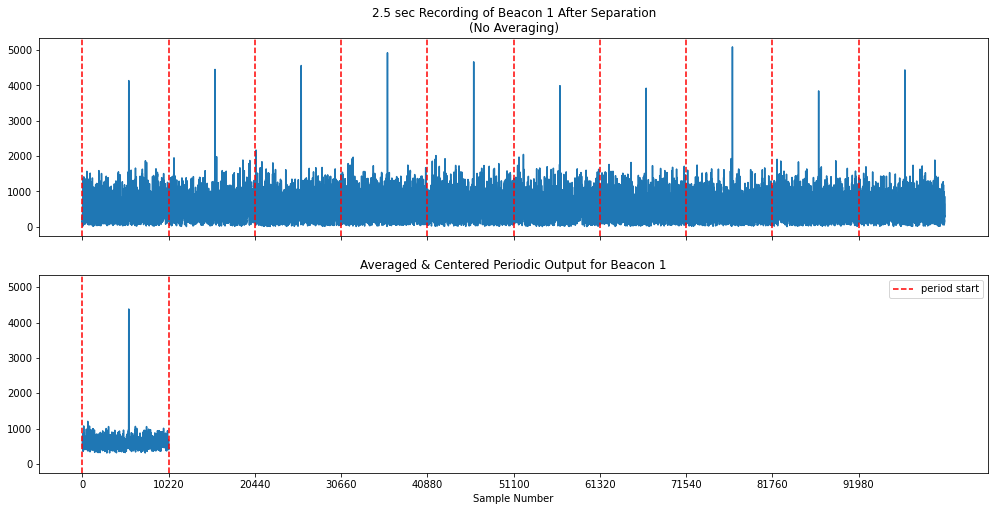

In [9]:
plot_average_multiple_signals()

**<span style="color:red">What is the effect of averaging? Why would this be useful?</span>**

**`The affect of averaging greatly reduces noise`**

<a id='task5'></a>
# <span style="color:blue">Task 5: Computing Distances</span>

Cross-correlation analysis allows us to determine the time delays between the arrivals of different beacon signals at the receiver. We need to determine a method to convert between these time delays and physical distances. To do so, we must first be able to convert the time delays in samples to real values of time. As previously discussed, the beacons begin transmitting at an unknown time. However, we can compute arrival times relative to a particular **reference beacon**, treating this beacon as having arrived at $t=0$.

For example, we can choose **`beacon0`** to be the reference beacon. Then, the peak corresponding to **`beacon0`** is considered to be $t=0$. If the cross-correlation peak corresponding to **`beacon1`** occurs 300 samples after the **`beacon0`**, we can conclude that **`beacon1`** was received at $t=300$. 

The relative times of arrival (in units of samples) which we will call **offsets** are all defined  **offset** with respect to **`beacon0`** (or any other beacon of our choice). You can then convert offsets in samples to time delays in seconds at a known sampling frequency $f$ (this frequency determines the duration in seconds of each discrete time interval $T$). <br><br>

**<span style="color:red">According to our definition above what is the offset of `beacon0`?</span>**

**`The offset of beacon 0 is 0`**

**<span style="color:red">If `beacon2` arrives 450 samples later than `beacon0`, what is the *time* difference of arrival (in seconds) given that our sampling rate is $f_s=44100$ Hz?</span>**  <br><br> **Hint: the formula $T = \frac{1}{f}$ will be useful**, where T and f are defined above.

**`1/98`**

In [ ]:
plot_shifted(identify_peak)

Note a beacon may arrive before our reference signal, if the first signal to arrive at the receiver was not chosen as the reference signal. These beacons have a negative offset. 

In the following exercises, you have been provided with code to center the received signal about the reference signal **`beacon0`** at sample 0 as above. You will need to complete the rest of each function as specified in the docstrings.

<a id='task5a'></a>
# <span style="color:blue">Task 5a: Identifying Offsets</span>

**<span style="color:red">Complete the function below which returns relative offsets (in units of samples) given a list of input signals.</span>**

In [ ]:
def identify_offsets(averaged):
    """ Compute the offset (in units of samples) of each signal relative to the reference beacon by
    identifying the peak of each signal (absolute offset) and 
    subtracting the peak of the reference beacon's signal from it (relative offset).
    
    (The first line of code centers the signals about the peak corresponding to the reference beacon for you.)
    
    Functions to Use: identify_peak
    
    Args:
    averaged (list): the output of the average_multiple_signals() function (a list of single period cross correlated sigs)
    
    Returns (list): a list containing the offset of each input signal relative to the reference beacon (beacon0)
    """
    # Reshaping the input so that all of our signals are centered about the peak corresponding to beacon0
    shifted = [np.roll(avg, len(averaged[0]) // 2 - identify_peak(averaged[0])) for avg in averaged]
    beacon0_offset = identify_peak(shifted[0])

    # shifted:
    #     shifted is a nested array where each element of the array is
    #     a shifted signal that is centered about the peak corresponding to beacon0 
    # beacon0_offset:
    #     The absolute offset that beacon0 starts at
    # YOUR TASK: Return a list of relative offsets (where each beacon starts relative to
    #            where beacon0 starts). This means that beacon0's offset should be 0.
    
    # Use `shifted` and `beacon0_offset` to determine the relative offsets of other beacons
    
    rv = []
    for x in shifted: 
        rv.append(identify_peak(x) - beacon0_offset)
    return rv
    #return [identify_peak(x) - beacon0_offset for x in shifted]

**<span style="color:red">Run the cell below to test identify_offsets().</span>**

In [ ]:
test_identify_offsets(identify_offsets)

Now you must convert the offsets you just computed in samples to the time difference of arrivals (TDOAs) that will be used to determine relative distances.

**<span style="color:red">Given that the microphones sample at a rate of $f_s=44100$ Hz, complete the function `offset_to_tdoas` below, which takes a list of offsets and a sampling frequency, and returns a list of TDOA's.</span>**
<br/>
*Hint: What is the relationship between sampling frequency, number of samples, and time?*

In [ ]:
def offsets_to_tdoas(offsets, sampling_freq):
    """ Convert a list of offsets to a list of TDOA's
   
    Args:
    offsets (list): list of offsets in samples
    sampling_freq (int): sampling frequency in Hz
    
    Returns (list): a list of TDOAs corresponding to the input offsets
    """
    return [offset / sampling_freq for offset in offsets]

**<span style="color:red">Run the cell below to test offsets_to_tdoas().</span>**

In [ ]:
test_offsets_to_tdoas(offsets_to_tdoas)

<a id='task5a'></a>
# <span style="color:blue">Task 5b: Combining Functions</span>
You have written a variety of helper functions to perform each step of the processing required to go from the received signal at the microphone to a list of TDOAs. You will now consolidate these steps into one convenient method.

**<span style="color:red">Implement a function that will take in the recorded microphone signal and output the offsets of each component beacon signal in units of *samples*.</span>**

In [ ]:
def signal_to_offsets(raw_signal):
    """ Compute a list of offsets from the microphone to each speaker.
    
    Functions to use: separate_signal, average_multiple_signals, identify_offsets
    
    Args:
    raw_signal (np.array): raw received signal from the microphone (e.g. no separation, averaging, etc).
    
    Returns (list): offset for each beacon (beacon0, beacon1, etc). in samples
    """
    return identify_offsets(average_multiple_signals(separate_signal(raw_signal)))

Given the raw received signal, you can now compute the offsets in time steps relative to a single beacon. Suppose that we are also given $t_0$: the time at which our reference beacon arrived at the receiver, i.e the time at which **`beacon0`** arrived as measured by our stopwatches or clocks since the beacons began emitting signals. We could then determine the real time that each beacon arrived at the receiver, as opposed to just relative time delays. Using these time delays $t_i$, you can calculate the distance $d_i$ between the receiver and each beacon using $d_i = v \cdot t_i$, where $v \approx 340 ms^{-1}$ is the speed of sound. Finally, the location of the receiver can be determined with these distances and some simple geometry. This is precisely what GPS does using high frequency electromagnetic waves instead of sound.

**<span style="color:red">Implement a function, `signal_to_distances`, which takes a recorded signal at the receiver and the time of arrival of the first beacon signal, and returns a list of the distance from the microphone to each speaker.</span>**
<br> *Hint: You may wish to take advantage of a function that computes the offsets given the raw microphone signal.*

In [ ]:
v_air = 340.29
sampling_freq = 44100

def signal_to_distances(raw_signal, t0):
    """ Returns a list of distances from the microphone to each speaker.
    
    Functions to use: offsets_to_tdoas, signal_to_offsets
    
    Args:
    raw_signal (np.array): recorded signal from the microphone
    t0 (float): reference time for beacon0 in seconds
    
    Returns (list): distances to each of the speakers (beacon0, beacon1, etc). in meters
    
    You will have to use v_air and sampling_freq above
    """
    lst = []
    for x in offsets_to_tdoas((signal_to_offsets(raw_signal)), sampling_freq):
        lst.append((x*v_air + v_air*t0))
    return lst

**<span style="color:red">Run the cell below to test signal_to_distances(). DO NOT move on before passing this test.</span>**

In [ ]:
test_signal_to_distances(signal_to_distances)

After computing the distances from each speaker, you can use the Cartesian formula for the distance between two coordinates: $d = \sqrt{(x-x_{speaker})^2 + (y-y_{speaker})^2}$, to construct a system of equations and solve for the exact position of the receiver! Rather than solving for the exact coordinates in this lab, we will instead visualize the positions of each beacon on a graph.

<a id='visualization'></a>
# <span style="color:blue">Visualization</span>

**<span style="color:red">Run the following block to simulate speakers located at (0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5) on a 2D plane and a microphone located at (1.2, 3.6).</span>**

In [ ]:
# Assume the time of arrival of the first beacon is 0.011151468430462413.
Lab.generate_raw_signal([1.2, 3.6])
raw_signal = Lab.demodulate_signal(Lab.rawSignal)
distances = signal_to_distances(raw_signal, 0.011151468430462413)
distances = distances[:5]
print(("The distances are: " + str(distances)))

# Plot the speakers
Lab.plot_speakers(plt, [(0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5)], distances, xlim=(-8, 8), ylim=(-16/3, 16/3))
plt.show()

Our current model of an Acoustic Positioning System relies on the ability to know the time of arrival of the reference beacon, and further assumes that all the distances from each speaker to the receiver will agree on one unique location, i.e the system of equations has a unique solution. However, it is impossible to determine when the first beacon arrives at the receiver in practice, since this would involve complicated clock synchronization schemes that are impractical at the distances that satellites operate at. Furthermore, data is always noisy in the real world, and it may therefore be impossible to determine a unique location for the receiver. You will learn a new technique in lecture to help circumvent the latter issue, but we will still need to develop a better model that does not require the provision of the reference beacon's time of arrival. You will see how this is done in APS 2.

<a id='task6'></a>
# <span style="color:blue">Task 6: Testing Signal to Offset Conversion with Real Data</span>

Finally, we will test the functions you have written on some real data, taken from the setup you will use in APS 2. Run the following code blocks to load in the data and plot the results.

In [ ]:
received_signal = load('sig.npy')

# Plot the received signal
plt.figure(figsize=(18,4))
plt.plot(received_signal)

**<span style="color:red">Test your code** (It is okay if your results are slightly off.)

In [ ]:
offsets = signal_to_offsets(Lab.demodulate_signal(received_signal))
print("Expected: " + str([0, 250, 540, -321]))
print("Got: " + str(offsets[:4]))

You are almost ready to locate a real receiver, and are finished for today. The next lab will go over techniques to circumvent some of the issues discussed above.

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off,
1. Fill out the checkoff google form. **[Checkoff Form](https://forms.gle/3RemPsckTCDggJmk6
)**
2. Submit a **checkoff** request on the lab queue. **[Checkoff queue](https://lab.eecs16a.org)** It is fine if only one person from your group submits the queue request, but everyone must submit their own google form. 

Your GSI or a Lab Assistant will join your breakout room when they are available and go through some checkoff questions with your group. They will go through the checkoff list in order. Please be patient!